# ОБУЧЕНИЕ И ОЦЕНКА РЕГРЕССИОННОЙ МОДЕЛИ ДЛЯ ПРЕДСКАЗАНИЯ ГЛУБИНЫ СЕЗОННОГО ПРОТАИВАНИЯ УЧ. ОЛЬСКИЙ ПЕРЕВАЛ (МАГАДАНСКАЯ ОБЛАСТЬ)

> **ДИСКЛЕЙМЕР:** не претендую на абсолютную правильность обучения модели и точность прогнозируемых данных. Пробую и исследую новое для себя направление :) 

**ЦЕЛЬ** -  обучить и оценить регрессионую модель на предсказание глубины сезонного протаивания грунтов по фактическим данным.

**Задачи:**
- подготовить данные
- выполнить предварительную обработку данных
- выполнить исследовательский анализ данных (корреляцию независимых переменных с зависимой, целевой переменной)
- отобрать и выделить признаки
- обучить и оценить качество модели

Работать будем с датасетом, который содержит данные по глубине сезонного протаивания, температуре воздуха, суммам отрицательных и положительных температур, коэффициенту морозности и температурам грунта на разных глубинах для участка "Ольский перевал" за 2009-2022 гг. (14 лет). Данные по глубине сезонного протаивания и температуре грунтов на разных глубинах были получены сотрудниками СВНИМС ИМЗ СО РАН [Рожина, 2023]. Массив значений, содержащий температуры воздуха, был предоставлен сайтом http://www.pogodaiklimat.ru/.

## Подготовка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# датасет с временным рядом
data = pd.read_excel(r'E:\2023\тюмень\4m_regression.xlsx', na_values=["."], parse_dates=["date"]) 

# выведем первые 5 строк
data.head() 

,date,CTC,air,FDD,DDT,F,3_m,5_m,10_m,15_m,20_m
0,2009-01-01,5.3,-1.653679,-2035.158929,1469.133333,0.540648,-1.100657,-1.283563,-1.517655,-1.599947,-1.605
1,2010-01-01,5.0,-2.905204,-2453.791071,1426.903571,0.567354,-1.465113,-1.262894,-1.375968,-1.473721,-1.600
2,2011-01-01,4.9,-1.713837,-1903.846429,1321.431071,0.545519,-1.116105,-1.161681,-1.275965,-1.403312,-1.440
3,2012-01-01,4.6,-3.166944,-2382.589286,1238.628571,0.581052,-0.803799,-0.505705,-1.272681,-1.477776,-1.520
4,2013-01-01,4.7,-1.815552,-2030.006548,1398.614286,0.546435,-1.456511,-0.704000,-1.499854,-1.670000,-1.530


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Датасет содержит данные о глубине сезонного протаивания, температуре воздуха, суммах отрицательных и положительных температур, коэффициента морозности и температуры грунта на разных глубинах для участка "Ольский перевал" за 2009-2022 гг. (14 лет).
    
</div>

## Предварительная обработка данных

Поработаем с пропусками

In [3]:
# посчитаем пропуски для каждого столбца
data.isnull().sum() 

date    0
CTC     1
air     0
FDD     0
DDT     0
F       0
3_m     1
5_m     1
10_m    1
15_m    1
20_m    0
dtype: int64

In [4]:
# заполним пропуски средним арифметическим между двумя соседними известными числами
data["CTC"] = data["CTC"].interpolate()
data["3_m"] = data["3_m"].interpolate()
data["5_m"] = data["5_m"].interpolate()
data["10_m"] = data["10_m"].interpolate()
data["15_m"] = data["15_m"].interpolate()

Необходимо определить тип переменных, с которым нам предстоит работать. От этого будет зависеть, какие статистические графики и инструменты мы будем применять при анализе данных.

In [5]:
# для этого есть метод .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    14 non-null     datetime64[ns]
 1   CTC     14 non-null     float64       
 2   air     14 non-null     float64       
 3   FDD     14 non-null     float64       
 4   DDT     14 non-null     float64       
 5   F       14 non-null     float64       
 6   3_m     14 non-null     float64       
 7   5_m     14 non-null     float64       
 8   10_m    14 non-null     float64       
 9   15_m    14 non-null     float64       
 10  20_m    14 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.3 KB


Все переменные, кроме даты, являются количественными (тип float). Мы можем посмотреть основные статистические показатели (summary statistics):

In [6]:
# для этого воспользуемся методом .describe() и округлим значения
data.describe().round(2)

,CTC,air,FDD,DDT,F,3_m,5_m,10_m,15_m,20_m
count,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00
mean,4.99,-1.96,-2097.29,1403.60,0.55,-0.79,-1.00,-1.32,-1.38,-1.41
std,0.32,0.67,229.71,71.96,0.01,1.13,0.34,0.13,0.19,0.13
min,4.50,-3.17,-2453.79,1238.63,0.53,-1.64,-1.46,-1.52,-1.67,-1.60
25%,4.75,-2.53,-2287.98,1379.15,0.54,-1.41,-1.25,-1.41,-1.50,-1.52
50%,5.05,-1.76,-2052.74,1412.76,0.55,-1.10,-1.10,-1.31,-1.37,-1.42
75%,5.25,-1.53,-1930.08,1458.85,0.56,-0.86,-0.76,-1.25,-1.22,-1.32
max,5.50,-0.96,-1771.62,1501.61,0.58,2.62,-0.29,-1.10,-1.08,-1.23


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Выполнили предварительную обработку данных - заменили пропуски на среднее арифметическое между двумя соседними известными числами и перевели данные столбца с датами в верный формат. Это необходимо для дальнейшего обучения модели.
    
В частности, вывели количество наблюдений (count), среднее арифметическое (mean), среднее квадратическое отклонение (std), минимальное (min) и максимальное (max) значения, а также первый (25%), второй (50%) и третий (75%) квартиль (второй квартиль это то же самое, что медиана) каждой количественной переменной.
    
</div>

## Исследовательский анализ данных

После предобработки данных выполним исследовательский или разведочный анализ данных (Exploratory Data Analysis, EDA). По большом счету, от нас требуется понять какие взаимосвязи мы можем выявить между переменными, чтобы потом построить модель.

Основной инструмент, который нам доступен на данный момент, это корреляция независимых переменных (признаков, описывающих природные условия) с зависимой, целевой переменной (глубиной сезонного протаивания грунтов). Сильная корреляция - когда значение приближается к 1 или −1, ее отсутствие - когда значение близко к нулю.

Посчитаем коэффициент корреляции для всего датафрейма и округлим значение

In [7]:
# посчитаем коэффициент корреляции для всего датафрейма и округлим значение
corr_matrix = data.corr().round(2)
corr_matrix

,CTC,air,FDD,DDT,F,3_m,5_m,10_m,15_m,20_m
CTC,1.00,0.28,0.13,0.62,-0.38,0.21,-0.13,-0.30,-0.28,-0.25
air,0.28,1.00,0.96,0.30,-0.99,0.27,0.10,0.07,0.06,0.25
FDD,0.13,0.96,1.00,0.02,-0.91,0.27,0.21,0.08,-0.04,0.19
DDT,0.62,0.30,0.02,1.00,-0.44,0.00,-0.35,-0.11,0.21,0.11
F,-0.38,-0.99,-0.91,-0.44,1.00,-0.24,-0.02,-0.03,-0.06,-0.22
3_m,0.21,0.27,0.27,0.00,-0.24,1.00,0.74,-0.15,-0.06,0.25
5_m,-0.13,0.10,0.21,-0.35,-0.02,0.74,1.00,-0.06,-0.24,0.05
10_m,-0.30,0.07,0.08,-0.11,-0.03,-0.15,-0.06,1.00,0.81,0.61
15_m,-0.28,0.06,-0.04,0.21,-0.06,-0.06,-0.24,0.81,1.00,0.83
20_m,-0.25,0.25,0.19,0.11,-0.22,0.25,0.05,0.61,0.83,1.00


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Такой способ представления корреляции называется корреляционной матрицей. В ней, в частности, мы видим (смотрите на первый столбец или строку), что переменная DDT (сумма положительных температур) имеет достаточно заметную корреляцию с целевой переменной СТС, 0,62. Умеренная обратная - с коэффициентом морозности (F) и температурой на глубине 10 м.
    
</div>

Взаимосвязь двух переменных также можно визуализировать с помощью диаграммы рассеяния.

Text(0.5, 1.0, 'Глубина СТС и DDT')

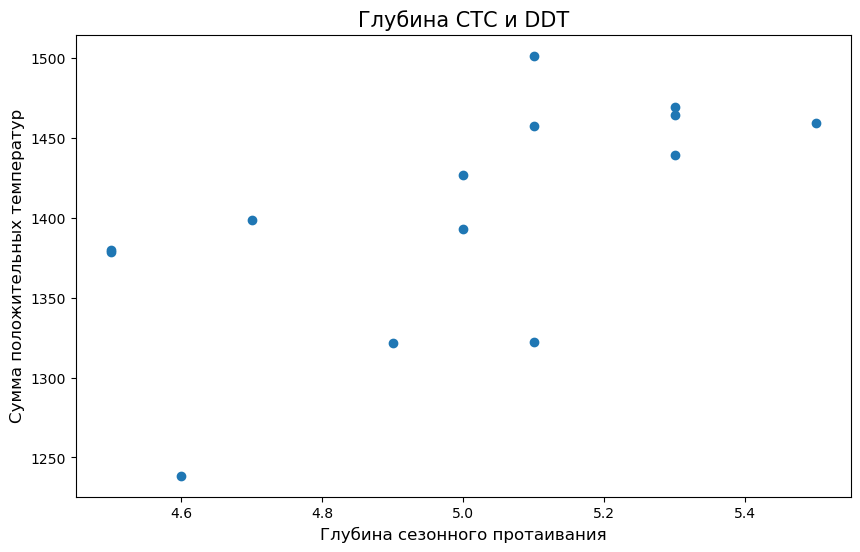

In [8]:
# зададим размер и построим график
plt.figure(figsize = (10,6))
plt.scatter(x=data['CTC'], y=data['DDT'])
 
# добавим подписи
plt.xlabel('Глубина сезонного протаивания', fontsize = 12)
plt.ylabel('Сумма положительных температур', fontsize = 12)
plt.title('Глубина СТС и DDT', fontsize = 15)

## Отбор и выделение признаков

После сбора данных о взаимосвязи переменных, можем начать отбор наиболее значимых признаков (feature selection) и создание или выделение новых (feature extraction). В текущим исследовании, в частности, мы возьмем переменные DDT, F и 10_m, поскольку они имеют наиболее высокую корреляцию с целевой переменной СТС. Создавать новые признаки мы пока не будем.

Поместим наши признаки в переменную X, а глубину сезонного протаивания в переменную y.

In [9]:
# поместим наши признаки в переменную X, а глубины протаивания в переменную y
X = data[['DDT', 'F', '10_m']]
y = data['CTC']

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Как мы видим, большая часть времени уходит именно на подготовительные этапы работы с данными, а не на обучение модели и составление прогноза. Это нормально. 
    
</div>

## Обучение и оценка качества модели

После загрузки, предобработки и исследовательского анализа данных мы готовы к обучению модели. Вначале разобьем данные на обучающую и тестовую выборки.

In [10]:
# импортируем необходимый модуль
from sklearn.model_selection import train_test_split
 
# размер тестовой выборки составит 30%
# также зададим точку отсчета для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

Посмотрим на размерность новых наборов данных:

In [11]:
# размерность обучающей
print(X_train.shape, y_train.shape)
 
# и тестовой выборки
print(X_test.shape, y_test.shape)

(9, 3) (9,)
(5, 3) (5,)


Теперь обучим модель и сделаем прогноз.

In [12]:
# из набора линейных моделей библиотеки sklearn импортируем линейную регрессию
from sklearn.linear_model import LinearRegression
 
# создадим объект этого класса и запишем в переменную model
model = LinearRegression()
 
# обучим нашу модель
model.fit(X_train, y_train)

LinearRegression()

In [13]:
# на основе нескольких независимых переменных (Х) предскажем глубины протаивания (y)
y_pred = model.predict(X_test)
 
# выведем первые пять значений с помощью диапазона индексов
print(y_pred[:5])

[4.89685515 5.15704381 5.23787931 4.92549328 4.74998958]


Осталось оценить качество модели. Посчитаем среднеквадратическую ошибку.

In [14]:
# импортируем библиотеку
from sklearn import metrics
 
# выведем корень среднеквадратической ошибки
# сравним тестовые и прогнозные значения глубин сезонного протаивания
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Root Mean Squared Error (RMSE): 0.2534970060378631


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Среднеквадратическая ошибка RMSE равна 0.25. Это говорит нам о том, что среднее отклонение между прогнозируемыми набранными баллами и фактическими набранными баллами равно 0.25.

На практике мы обычно подгоняем несколько моделей регрессии к набору данных и вычисляем среднеквадратичную ошибку (RMSE) каждой модели. Затем мы выбираем модель с самым низким значением RMSE в качестве «лучшей» модели, потому что именно она делает прогнозы, наиболее близкие к фактическим значениям из набора данных.
    
</div>


И рассчитаем критерий качества — коэффициент детерминации (R2 или R-квадрат). R2 показывает, какая доля изменчивости целевой переменной объясняется с помощью нашей модели.

In [15]:
# рассчитаем критерий качества - коэффициент детерминации
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

R2: 0.11


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
В данном случае мы видим, что лишь 11% изменчивости глубины сезонного протаивания объясняется независимыми переменными, которые мы выбрали для нашей модели.
    
</div>

## Вывод

Для обучения и оценки регрессионной модели на прогноз глубины сезонного протаивания был использован массив данных, содержащий данные по глубине сезонного протаивания, температуре воздуха, суммах отрицательных и положительных температур, коэффициентам морозности и температурам грунта на разных глубинах для участка "Ольский перевал" за 2009-2022 гг. (14 лет).

За наиболее значимые признаки были взяты переменные суммы положительных температур, коэффициента морозности и температуры на глубине 10 м., поскольку они имеют наиболее высокую корреляцию с целевой переменной (глубиной сезонного протаивания).

После обучения регрессионной модели были получены следующие 5 прогнозных значений глубины сезонного протаивания - 4.9, 5.16, 5.28, 4.93 и 4.75 м. Полученные значения являются близкими к значениям, представленным в датасете.

Среднее отклонение между прогнозируемыми набранными значениями и фактическими набранными значениями составило 0.25. Коэффициент детерминации показал, что лишь 11% изменчивости глубины сезонного протаивания объясняется независимыми переменными, которые мы выбрали для нашей модели.


### Литература

1. https://digitrain.ru/articles/254066/
2. https://habr.com/ru/companies/ods/articles/327242/
3. https://www.dmitrymakarov.ru/intro/regression-14/#4-etap-2-predvaritelnaya-obrabotka-dannykh
4. Рожина М.С., Железняк М.Н. Реакция деятельного слоя на изменение климата в зоне прерывистого распространения мерзлоты в Магаданской области. Сборник тезисов Научной конференции с международным участием «Актуальные проблемы и перспективы развития геокриологии», посвященная 150-летию и 100-летию со дня рождения ученых-мерзлотоведов Михаила Ивановича Сумгина и Кирилла Фабиановича Войтковского, Якутск (27 июня–30 июня 2023 г.)